In [1]:
import os

os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.0/bin")
os.add_dll_directory("C:/tools/cuda/bin")

<AddedDllDirectory('C:/tools/cuda/bin')>

In [44]:
import tensorflow as tf
from utils.conf import ROOT_DIR
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [75]:
def loading_data(path, img_size):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append(img_resize)
    return data

In [95]:
src_data = os.path.join(ROOT_DIR,"SOCOFing")
easy_data = loading_data(os.path.join(src_data, os.path.join("Altered","Altered-Easy")), img_size=28)
medium_data = loading_data(os.path.join(src_data, os.path.join("Altered","Altered-Medium")), img_size=28)
hard_data = loading_data(os.path.join(src_data, os.path.join("Altered","Altered-Medium")), img_size=28)

loading data from:  C:\Users\anass\my_ds\fingerprint_class\SOCOFing\Altered\Altered-Easy
loading data from:  C:\Users\anass\my_ds\fingerprint_class\SOCOFing\Altered\Altered-Medium
loading data from:  C:\Users\anass\my_ds\fingerprint_class\SOCOFing\Altered\Altered-Medium


In [96]:
data = np.concatenate([easy_data, medium_data, hard_data], axis=0)

In [97]:
x_train, x_test = train_test_split(data, test_size=0.2, random_state=0)

In [114]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)


AttributeError: 
        'EagerTensor' object has no attribute 'astype'.
        If you are looking for numpy-related methods, please run the following:
        import tensorflow.python.ops.numpy_ops.np_config
        np_config.enable_numpy_behavior()

In [115]:
print (x_train.shape)
print (x_test.shape)

(41652, 28, 28, 1)
(10413, 28, 28, 1)


In [122]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(16, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(8, (3,3), activation='relu', padding='same')
        ])
        self.decoder = tf.keras.Sequential([
          layers.Conv2D(8, (3,3), activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [123]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [124]:
tf.keras.backend.clear_session()
with mirrored_strategy.scope():
    autoencoder = Autoencoder(latent_dim)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
326/326 [==============================] - 7s 13ms/step - loss: 0.0436 - val_loss: 0.0323
Epoch 2/30
326/326 [==============================] - 3s 9ms/step - loss: 0.0312 - val_loss: 0.0300
Epoch 3/30
326/326 [==============================] - 3s 9ms/step - loss: 0.0295 - val_loss: 0.0288
Epoch 4/30
326/326 [==============================] - 3s 9ms/step - loss: 0.0287 - val_loss: 0.0288
Epoch 5/30
326/326 [==============================] - 3s 8ms/step - loss: 0.0281 - val_loss: 0.0277
Epoch 6/30
326/326 [==============================] - 3s 8ms/step - loss: 0.0277 - val_loss: 0.0274
Epoch 7/30
326/326 [==============================] - 3s 9ms/step - loss: 0.0273 - val_loss: 0.0270
Epoch 8/30
326/326 [==============================] - 3s 9ms/step - loss: 0.0270 - val_loss: 0.0268
Epoch 9/30
326/326 [==============================] - 3s 8ms/step - loss: 0.0268 - val_loss: 0.0266
Epoch 10/30
326/326 [==============================] - 3s 9ms/step - loss: 0.0265 - val_loss: 0.026

In [125]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

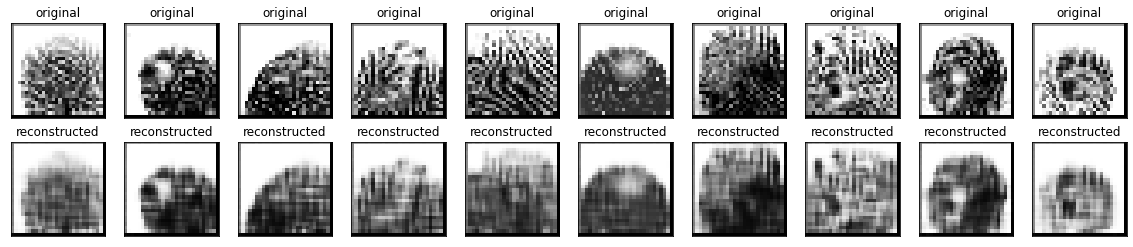

In [126]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [128]:
decoded_imgs.shape

(10413, 28, 28, 1)